In [203]:
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urljoin
import time
import logging
import csv
from tqdm import tqdm
import glob

GRAPHSQL_URL = "http://192.168.20.241:9000/query/OneMonthNet/"

############################ util functions ############################
def query_graphsql_ori(query_name, para_string):
    remaining_url = "{}?{}".format(query_name, para_string)
    url=urljoin(GRAPHSQL_URL, remaining_url)
    print('query:{}\nparas:{}\nrequest for url: {}'.format(query_name, para_string.split('&'), url))
    print('---------------------------------------------------------------------------------------------------')
    result = requests.get(url)
    result_json = json.loads(result.text)
    return result_json


def query_graphsql(query_name, para_string):
    remaining_url = "{}?{}".format(query_name, para_string)
    url=urljoin(GRAPHSQL_URL, remaining_url)
    st = time.time()
    print('query:{}\nparas:{}\nrequest for url: {}'.format(query_name, para_string.split('&'), url))
    print('---------------------------------------------------------------------------------------------------')
    try:
        result = requests.get(url)
        result_json = json.loads(result.text)
        if result_json['error']:
            logging.error(result_json['message'])
            print('run query failed')
            return None
        print('run query finish, use {} seconds\n\n'.format(time.time() - st))
        return result_json
    except Exception as e:
        print('failed')
        
        
def _update_max_min_date(node_name):
    '''
    get the max & min date for the given node type based on its history update dates;
    para: node_name: 'Device'; check all the node_name type in gsql graph schema: OneMonthNet;
    '''
    query_name = 'update_max_min_date'
    paras = 'node={}'.format(node_name)
    return query_graphsql(query_name, paras)


def _node_cutoff_filter(start_time, end_time, node_type):
    '''
    note that call _update_max_min_date before run this query;
    select those nodes with given node_type exist between start_time and end_time;
    paras:start_time:'2019-06-01 18:42:22'
    paras:end_time:'2019-07-01 18:42:22'
    paras:node_type:'User'; check all the node_name type in gsql graph schema: OneMonthNet;
    '''
    query_name = 'node_cutoff_filter'
    paras = 'start_t={}&end_t={}&node={}'.format(start_time, end_time, node_type) 
    return query_graphsql(query_name, paras)
    
    
########################################################################

# def label_get(start_date):
#     'old version and has been deprecated now, pls use label_get2 query;'
#     query_name = 'label_get'
#     paras = 'start_date={}'.format(start_date) 
#     return query_graphsql(query_name, paras)


def label_get2(start_date, end_date, loanstyle):
    '''
    get loans with the given loanstyle whose fundtime between start_date & end_date;
    paras: start_date: '2019-06-01 00:00:00'
    paras: end_date: '2019-07-01 00:00:00'
    paras: loanstyle: '绿卡30天1期'
    '''
    query_name = 'label_get2'
    paras = 'start_date={}&end_date={}&loan_type={}'.format(start_date, end_date, loanstyle) 
    return query_graphsql(query_name, paras)['results'][0]['loanlabelSHOW']

#1
def reset(node):
    '''
    '''
    query_name = 'reset'
    paras = 'node={}'.format(node) 
    return query_graphsql(query_name, paras)

#2
def pageRank_train(start_t, end_t, node, maxChange, maxIter, damping, query_name):
    '''
    '''
    paras = 'start_t={}&end_t={}&node={}&maxChange={}&maxIter={}&damping={}'.format(start_t, end_t, node, maxChange,maxIter,damping) 
    return query_graphsql(query_name, paras)

#3
def pageRank_appr_files(file_abs_path, query_name):
    '''
    draft 1 for pageRank in cashbus graph; 
    Only works for user-device relationship(single edge type & double vertex type);
    Only output nodes(type: user or device) with pg_score !=0;
    '''
    paras = 'file_path={}'.format(file_abs_path) 
    return query_graphsql(query_name, paras) 

#2
def connected_comp_train(start_t, end_t, node, query_name='conn_comp'):
    '''
    '''
    paras = 'start_t={}&end_t={}&node={}'.format(start_t, end_t, node) 
    return query_graphsql(query_name, paras)

#3
def connected_comp_appr_files(file_abs_path, query_name):
    '''
    draft 1 for pageRank in cashbus graph; 
    Only works for user-device relationship(single edge type & double vertex type);
    Only output nodes(type: user or device) with pg_score != 0;
    '''
    paras = 'file_path={}'.format(file_abs_path)
    return query_graphsql(query_name, paras)


def train(st, et, node_type, reset_bool):
    """
    paras: st: start time of a period, only node within the restriction will be trained and given a pgscore;
    paras: et: end time of the period;
    paras: node_type: determine which nodetype will be trained;
    """
    
    assert node_type in ["Device", "PhoneNumber"]
    
    if reset_bool:
        reset(node_type)
    pageRank_train(st, 
                   et, 
                   node_type, 
                   10, 3, 0.6,
                   "pageRank_train_{}".format(node_type.lower()))
    return None



def test_with_local_files(nodetype, file_path):
    """
    paras: node_type: determine which nodetype will be test;
    paras: file_path: only provide a path to save test nodes id;
    """
    test_res2 = pageRank_appr_files(file_path, 
                                    "pageRank_appr_files_{}".format(nodetype.lower()))
    user_pg_res = [i['attributes'] for i in test_res2['results'][0]['test_set']]
    user_pg_df2 = pd.DataFrame.from_dict(user_pg_res)
    user_pg_df2.rename(columns={'prim_id': 'username'}, inplace=True)
    return test_res2, user_pg_df2


In [205]:
connected_comp_train('2019-06-13 00:00:00', '2019-06-15 00:00:00', 'PhoneNumber')

query:conn_comp
paras:['start_t=2019-06-13 00:00:00', 'end_t=2019-06-15 00:00:00', 'node=PhoneNumber']
request for url: http://192.168.20.241:9000/query/OneMonthNet/conn_comp?start_t=2019-06-13 00:00:00&end_t=2019-06-15 00:00:00&node=PhoneNumber
---------------------------------------------------------------------------------------------------
run query finish, use 2.4740493297576904 seconds




{'version': {'api': 'v2', 'schema': 0},
 'error': False,
 'message': '',
 'results': [{'Start': []}]}

In [5]:
label1 = pd.read_csv('/data-0/gsm/qb_one_month/loan_label_1_1901_1907.csv')
label2 = pd.read_csv('/data-0/gsm/qb_one_month/loan_label_2_new_1901_1907.csv')
label2.columns = list(label1.columns)+['nouse']

# xiaomajie 给的表；
loan_detail_08_09_df = pd.read_csv('/data-0/qibo/Gdata/oneMonth/qb_temp_loan_detail_08_09.csv')
loan_detail_08_09_df.username = loan_detail_08_09_df.username.astype(str)

# device 表；
device_log = pd.read_csv('/data-0/qibo/Gdata/oneMonth/device/device_log_1901_1907.csv')



def test_loan_info(loanstyle, st, et):
    # 给定两个时间范围，给出所在时间内的 funded loan 信息；
    temp1 = label1[(label1.funddate<et)&(label1.funddate>=st)]
    temp2 = label2[(label2.funddate<et)&(label2.funddate>=st)]
    final = temp1.append(temp2)
    if loanstyle == 'all':
        return final
    return final[final.loanstyle == loanstyle]


def source_table(loanstyle, st, et):
    #xiaomajie biao;
    test_funded_loans = loan_detail_08_09_df[(loan_detail_08_09_df.fundtime>=st)&(loan_detail_08_09_df.fundtime<et)]
    #label 表;
    test_label = test_loan_info(loanstyle, st, et)
    #merge;
    table3 = pd.merge(test_funded_loans, test_label, on='loanid')
    return table3

def final_process(source_df, save_path=None):
    ori, RES_phone = test_with_local_files(nodetype = "PhoneNumber", file_path = test_day_file)
    final = pd.merge(source_df, RES_phone, on='username')
    final = final[~final.default_now.isnull()]
    if save_dir is not None:
        final.to_csv(save_path)
    return final

def analysis(final_save_path):
    temp = pd.read_csv(final_save_path)[['default_now','@received_score','temp_save_bool']]
    temp['score_box'] = pd.qcut(temp['@received_score'].values, 5, labels=["very_low","low", "mid", "high","very_high"])
    temp['flag']=1
    temp1 = temp[temp.temp_save_bool==True]
    zz1 = pd.pivot_table(temp1,index=['score_box'], values=['@received_score','default_now','flag'], aggfunc=[np.sum,np.mean])

    temp2 = temp[temp.temp_save_bool==False]
    zz2 = pd.pivot_table(temp2,index=['score_box'], values=['@received_score','default_now','flag'], aggfunc=[np.sum,np.mean])
    return zz1, zz2, temp

def cal_ks(y, yhat):
    ks_dict = {}
    df = pd.DataFrame(columns=['label', 'score'])
    df.label = y
    df.score = yhat
    cross_freq = pd.crosstab(df.score, df.label)
    cross_dens = cross_freq.cumsum(axis=0)/(cross_freq.sum()+np.finfo(float).eps)
    cross_dens['gap'] = abs(cross_dens[0]-cross_dens[1])
    ks = cross_dens[cross_dens['gap'] == cross_dens['gap'].max()]
    return ks, cross_dens

In [183]:
####################### paras:      #####################
train_st = "2019-05-15 00:00:00"
train_et = "2019-06-14 00:00:00" 
test_st='2019-06-15 00:00:00'
test_et='2019-06-16 00:00:00'
save_dir = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_df/'
final_save_path = save_dir + "{}_{}.csv".format(test_st, test_et)

####################### train step: #####################
train(st=train_st, et=train_et, node_type="Device", reset_bool=True)

####################### test step:   #####################
source_df = source_table('绿卡30天1期', test_st, test_et)
test_day_file = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_{}_{}.txt'.format(test_st, test_et)
with open(test_day_file, 'w') as f1:
    csv_out = csv.writer(f1)
    for i in tqdm(source_df.username.unique()):
        csv_out.writerow([i])
        
####################### final step: ######################   
result = final_process(source_df, final_save_path)

query:reset
paras:['node=Device']
request for url: http://192.168.20.241:9000/query/OneMonthNet/reset?node=Device
---------------------------------------------------------------------------------------------------
run query finish, use 28.163514375686646 seconds


query:pageRank_train_device
paras:['start_t=2019-05-15 00:00:00', 'end_t=2019-06-14 00:00:00', 'node=Device', 'maxChange=10', 'maxIter=3', 'damping=0.6']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_train_device?start_t=2019-05-15 00:00:00&end_t=2019-06-14 00:00:00&node=Device&maxChange=10&maxIter=3&damping=0.6
---------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
100%|██████████| 4072/4072 [00:00<00:00, 940277.80it/s]

run query finish, use 7.754087686538696 seconds


query:pageRank_appr_files_phonenumber
paras:['file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-15 00:00:00_2019-06-16 00:00:00.txt']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_appr_files_phonenumber?file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-15 00:00:00_2019-06-16 00:00:00.txt
---------------------------------------------------------------------------------------------------


run query finish, use 0.8891208171844482 seconds




In [184]:
####################### paras:       #####################
train_st = "2019-05-14 00:00:00"
train_et = "2019-06-13 00:00:00" 
test_st='2019-06-14 00:00:00'
test_et='2019-06-15 00:00:00'
save_dir = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_df/'
final_save_path = save_dir + "{}_{}.csv".format(test_st, test_et)

####################### train step:  #####################
train(st=train_st, et=train_et, node_type="Device", reset_bool=True)

####################### test step:   #####################
source_df = source_table('绿卡30天1期', test_st, test_et)
test_day_file = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_{}_{}.txt'.format(test_st, test_et)
with open(test_day_file, 'w') as f1:
    csv_out = csv.writer(f1)
    for i in tqdm(source_df.username.unique()):
        csv_out.writerow([i])
        
####################### final step:  ######################   
result = final_process(source_df, final_save_path)

query:reset
paras:['node=Device']
request for url: http://192.168.20.241:9000/query/OneMonthNet/reset?node=Device
---------------------------------------------------------------------------------------------------
run query finish, use 27.317282676696777 seconds


query:pageRank_train_device
paras:['start_t=2019-05-14 00:00:00', 'end_t=2019-06-13 00:00:00', 'node=Device', 'maxChange=10', 'maxIter=3', 'damping=0.6']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_train_device?start_t=2019-05-14 00:00:00&end_t=2019-06-13 00:00:00&node=Device&maxChange=10&maxIter=3&damping=0.6
---------------------------------------------------------------------------------------------------
run query finish, use 7.400910377502441 seconds




/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
100%|██████████| 4342/4342 [00:00<00:00, 794852.83it/s]


query:pageRank_appr_files_phonenumber
paras:['file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-14 00:00:00_2019-06-15 00:00:00.txt']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_appr_files_phonenumber?file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-14 00:00:00_2019-06-15 00:00:00.txt
---------------------------------------------------------------------------------------------------
run query finish, use 0.8797504901885986 seconds




In [185]:
####################### paras:       #####################
train_st = "2019-05-13 00:00:00"
train_et = "2019-06-12 00:00:00" 
test_st='2019-06-13 00:00:00'
test_et='2019-06-14 00:00:00'
save_dir = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_df/'
final_save_path = save_dir + "{}_{}.csv".format(test_st, test_et)

####################### train step:  #####################
train(st=train_st, et=train_et, node_type="Device", reset_bool=True)

####################### test step:   #####################
source_df = source_table('绿卡30天1期', test_st, test_et)
test_day_file = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_{}_{}.txt'.format(test_st, test_et)
with open(test_day_file, 'w') as f1:
    csv_out = csv.writer(f1)
    for i in tqdm(source_df.username.unique()):
        csv_out.writerow([i])
        
####################### final step: ######################   
result = final_process(source_df, final_save_path)

query:reset
paras:['node=Device']
request for url: http://192.168.20.241:9000/query/OneMonthNet/reset?node=Device
---------------------------------------------------------------------------------------------------
run query finish, use 26.456817388534546 seconds


query:pageRank_train_device
paras:['start_t=2019-05-13 00:00:00', 'end_t=2019-06-12 00:00:00', 'node=Device', 'maxChange=10', 'maxIter=3', 'damping=0.6']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_train_device?start_t=2019-05-13 00:00:00&end_t=2019-06-12 00:00:00&node=Device&maxChange=10&maxIter=3&damping=0.6
---------------------------------------------------------------------------------------------------


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
  0%|          | 0/4339 [00:00<?, ?it/s]

run query finish, use 7.5084922313690186 seconds




100%|██████████| 4339/4339 [00:00<00:00, 812096.61it/s]


query:pageRank_appr_files_phonenumber
paras:['file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-13 00:00:00_2019-06-14 00:00:00.txt']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_appr_files_phonenumber?file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-13 00:00:00_2019-06-14 00:00:00.txt
---------------------------------------------------------------------------------------------------
run query finish, use 1.0216853618621826 seconds




In [186]:
####################### paras:       #####################
train_st = "2019-05-12 00:00:00"
train_et = "2019-06-11 00:00:00" 
test_st='2019-06-12 00:00:00'
test_et='2019-06-13 00:00:00'
save_dir = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_df/'
final_save_path = save_dir + "{}_{}.csv".format(test_st, test_et)

####################### train step:  #####################
train(st=train_st, et=train_et, node_type="Device", reset_bool=True)

####################### test step:   #####################
source_df = source_table('绿卡30天1期', test_st, test_et)
test_day_file = '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_{}_{}.txt'.format(test_st, test_et)
with open(test_day_file, 'w') as f1:
    csv_out = csv.writer(f1)
    for i in tqdm(source_df.username.unique()):
        csv_out.writerow([i])
        
####################### final step:  ######################   
result = final_process(source_df, final_save_path)

query:reset
paras:['node=Device']
request for url: http://192.168.20.241:9000/query/OneMonthNet/reset?node=Device
---------------------------------------------------------------------------------------------------
run query finish, use 28.58446741104126 seconds


query:pageRank_train_device
paras:['start_t=2019-05-12 00:00:00', 'end_t=2019-06-11 00:00:00', 'node=Device', 'maxChange=10', 'maxIter=3', 'damping=0.6']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_train_device?start_t=2019-05-12 00:00:00&end_t=2019-06-11 00:00:00&node=Device&maxChange=10&maxIter=3&damping=0.6
---------------------------------------------------------------------------------------------------
run query finish, use 7.5029051303863525 seconds




/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
100%|██████████| 4383/4383 [00:00<00:00, 890421.12it/s]


query:pageRank_appr_files_phonenumber
paras:['file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-12 00:00:00_2019-06-13 00:00:00.txt']
request for url: http://192.168.20.241:9000/query/OneMonthNet/pageRank_appr_files_phonenumber?file_path=/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_device/save_test_txt/test_2019-06-12 00:00:00_2019-06-13 00:00:00.txt
---------------------------------------------------------------------------------------------------
run query finish, use 0.7591190338134766 seconds




In [ ]:
t

In [63]:
glob.glob('/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/*')

['/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/2019-06-11 00:00:00_2019-06-12 00:00:00.csv',
 '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/2019-06-15 00:00:00_2019-06-16 00:00:00.csv',
 '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/2019-06-14 00:00:00_2019-06-15 00:00:00.csv',
 '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/2019-06-16 00:00:00_2019-06-17 00:00:00.csv',
 '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/2019-06-13 00:00:00_2019-06-14 00:00:00.csv',
 '/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/2019-06-12 00:00:00_2019-06-13 00:00:00.csv']

In [190]:
res_lis = glob.glob('/home/tigergraph/GraphProject/OneMonthGraph/Querys/G_algorithm/pagerank/dir_phone/save_df/*')

# zz1, zz2, temp = analysis(res_lis[2])
# cal_ks(temp['default_now'].values, temp['@received_score'].values)[0]


In [215]:
final_save_path = res_lis[3]

0.10454155955441302
2334


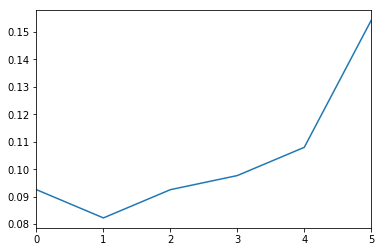

In [216]:
temp = pd.read_csv(final_save_path)[['default_now','@received_score','temp_save_bool']]
temp = temp[temp.temp_save_bool==False]
temp['score_box_ori'] = pd.qcut(temp['@received_score'].values, 6)
temp['score_box'] = pd.qcut(temp['@received_score'].values, 5, labels=["very_low","low", "mid", "high","very_high"])
temp['flag']=1

groups = temp.groupby('score_box_ori')
print(temp.default_now.sum()/temp.shape[0])
print(temp.shape[0])
DF = pd.DataFrame()
DF['group_idx'] = [idx for idx, gp in groups]
DF['group_default_ratio'] = [gp.default_now.sum()/gp.shape[0] for idx, gp in groups]
DF['group_size'] = [gp.shape[0] for idx, gp in groups]
DF.group_default_ratio.plot()

In [208]:
temp

,default_now,@received_score,temp_save_bool,score_box_ori,score_box,flag
4,0.0,0.63806,False,"(0.41, 0.745]",mid,1
9,0.0,2.40063,False,"(2.22, 23.256]",very_high,1
10,0.0,0.45745,False,"(0.41, 0.745]",low,1
12,0.0,0.03737,False,"(-0.001, 0.189]",very_low,1
20,0.0,1.55255,False,"(1.216, 2.22]",high,1
22,0.0,1.28466,False,"(1.216, 2.22]",high,1
26,0.0,0.42420,False,"(0.41, 0.745]",low,1
35,0.0,0.24566,False,"(0.189, 0.41]",low,1
39,0.0,3.40838,False,"(2.22, 23.256]",very_high,1
42,0.0,0.26922,False,"(0.189, 0.41]",low,1


In [328]:
from sklearn.metrics import roc_auc_score
# AUC 无意义原因在于， 它强调单调性，每一刀切下去，好坏两分;
# 可是如果 pg_score 意义非单调呢？ 即很高的不代表坏，很低的不代表坏，中间的坏；
roc_auc_score(MERGE['default_now'].values, MERGE['@received_score'].values)

0.46040655339805825

In [123]:
from itertools import combinations
import csv
from tqdm import tqdm


device_log = pd.read_csv('/data-0/qibo/Gdata/oneMonth/device/device_log_1901_1907.csv')

dic = {}
for index, row in tqdm(device_log.iterrows()):
    if row['userid'] not in dic:
        dic[row['userid']] = []
        dic[row['userid']].append(row['deviceid'])
    else:
        dic[row['userid']].append(row['deviceid'])

DIC = {}
for k,v in tqdm(dic.items()):
    DIC[k] = list(set(v))

with open('dict.txt', 'w') as f1:
    csv_out = csv.writer(f1)
    for k, v in tqdm(DIC.items()):
        temp = list(combinations(v, 2))
        if len(temp) != 0:
            for i in temp:
                csv_out.writerow(i)

In [194]:
device_log = pd.read_csv('/data-0/qibo/Gdata/oneMonth/device/device_log_1901_1907.csv')


device_log

In [218]:
len(device_log.deviceid.unique())

2834398